In [45]:
from duo_attn.utils import load_attn_pattern, sparsify_attention_heads
from duo_attn.patch import enable_duo_attention_eval
from transformers import LlamaModel
import transformers
import torch

# Load the model
model_ckt  = "models/Llama-3-8B-Instruct-Gradient-1048k"
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_ckt,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    attn_implementation="eager",
)

# Load the attention pattern
attn_heads, sink_size, recent_size = load_attn_pattern(
    "attn_patterns/Llama-3-8B-Instruct-Gradient-1048k/lr=0.02-reg=0.05-ctx=1000_32000-multi_passkey10"
)

# Sparsify attention heads
attn_heads, sparsity = sparsify_attention_heads(attn_heads, sparsity=0.5)

# Enable DuoAttention
enable_duo_attention_eval(
    model,
    attn_heads,
    sink_size=64,
    recent_size=256,
)

# Move model to GPU
model = model.cuda()

# Ready for inference!

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Enabling DuoAttention evaluation using sink size 64 and recent size 256
Enabling tuple KV cache for Llama


In [2]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm)

In [3]:
attn_heads

array([[0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 1., 1., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 1., 0.],
       [1., 0., 0., 1., 0., 1., 1., 0.],
       [1., 1., 1., 0., 1., 0., 1., 1.],
       [0., 0., 0., 1., 0., 1., 1., 1.],
       [1., 0., 0., 1., 1., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 0.],
       [1., 1., 1., 0., 1., 0., 1., 1.],
       [0., 1., 0., 0., 1., 1., 1., 1.],
       [1., 0., 1., 0., 1., 0., 1., 1.],
       [1., 1., 1., 0., 0., 1., 1., 0.],
       [1., 1., 0., 1., 0., 1., 1., 1.],
       [0., 1., 0., 1., 0., 1., 0., 0.],
       [1., 0., 1., 1., 0., 1., 0., 1.],
       [1., 0., 1., 1., 1., 1., 1., 0.],
       [1., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 1.],
       [1., 1., 0., 1., 0., 1., 1., 1.],
       [1., 0., 

In [66]:
import seaborn as sns
import torch

import matplotlib.pyplot as plt

# Extract the weights
q_weights = model.model.layers[20].self_attn.q_proj.weight.data
k_weights = model.model.layers[20].self_attn.k_proj.weight.data
v_weights = model.model.layers[20].self_attn.v_proj.weight.data

# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(q_weights.type(torch.cuda.FloatTensor).cpu().numpy(), cmap='viridis')
# plt.title('Heatmap of q_proj weights')
# plt.xlabel('Neuron')
# plt.ylabel('Weight')
# plt.show()


In [67]:
type(k_weights)

torch.Tensor

In [79]:
k_weights.shape

torch.Size([1024, 4096])

In [80]:
q_weights.shape

torch.Size([4096, 4096])

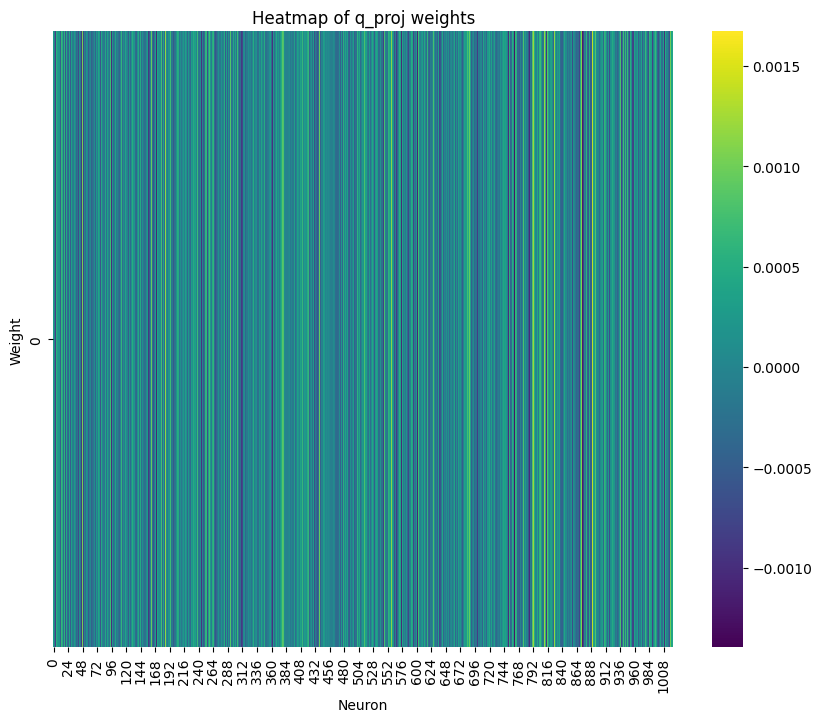

In [87]:
k = k_weights[None, ...].mean(-1)
# # Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(k.type(torch.cuda.FloatTensor).cpu().numpy(), cmap='viridis')
plt.title('Heatmap of q_proj weights')
plt.xlabel('Neuron')
plt.ylabel('Weight')
plt.show()

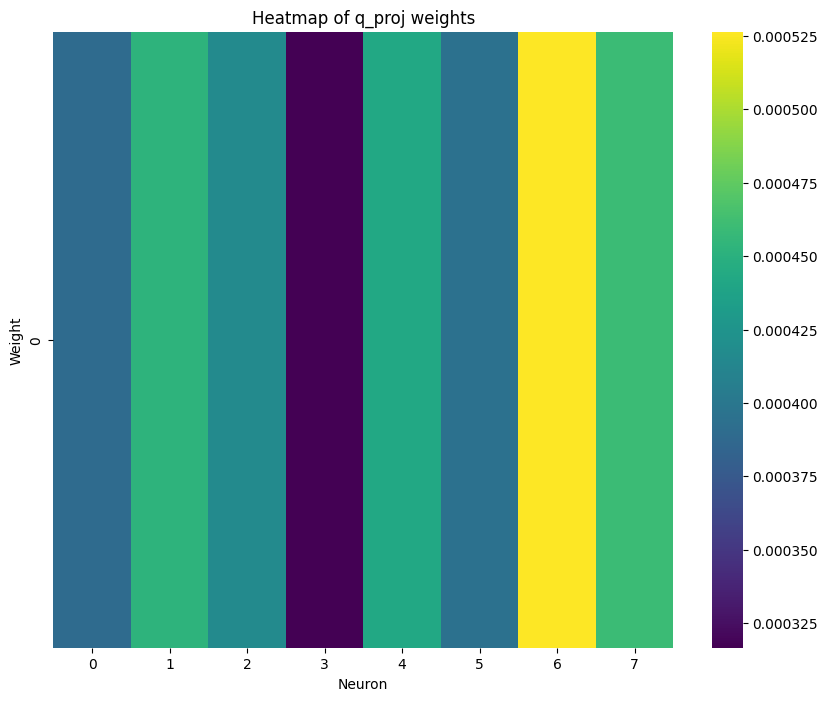

In [89]:
k = k_weights[None, ...].view(1, 8, 1024//8, 4096).mean(-1).std(-1)
# # Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(k.type(torch.cuda.FloatTensor).cpu().numpy(), cmap='viridis')
plt.title('Heatmap of q_proj weights')
plt.xlabel('Neuron')
plt.ylabel('Weight')
plt.show()

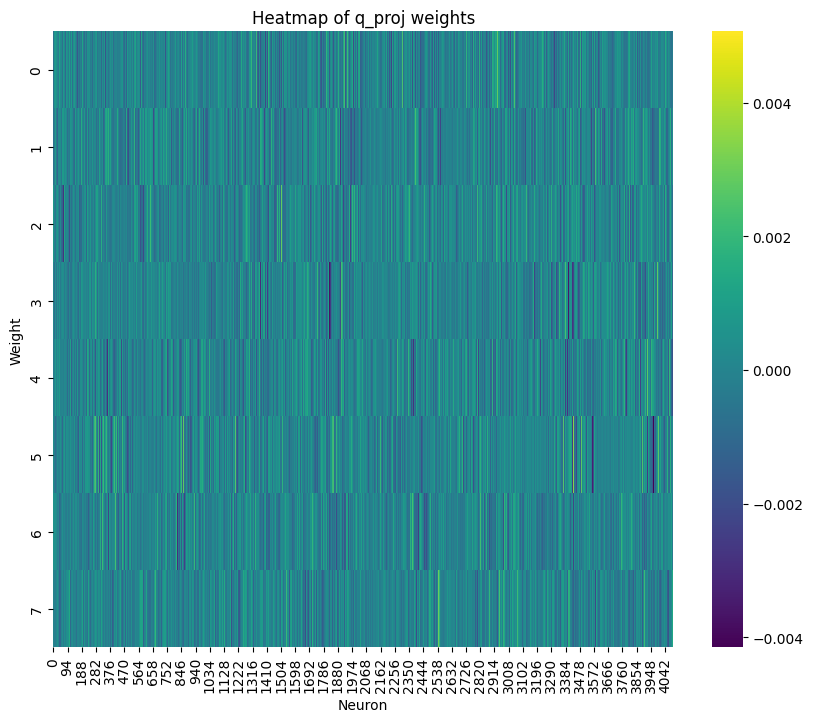

In [72]:
q = q_weights[None, ...].view((8, 4096, 4096//8)).mean(-1)
# # Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(q.type(torch.cuda.FloatTensor).cpu().numpy(), cmap='viridis')
plt.title('Heatmap of q_proj weights')
plt.xlabel('Neuron')
plt.ylabel('Weight')
plt.show()

In [44]:
attn_heads[20]

array([1., 0., 1., 1., 1., 1., 1., 0.])

In [46]:

from transformers import AutoTokenizer 

prompt = """
Pre-filling latency and memory usage of DuoAttention compared to full attention across varying pre-filling 
chunk sizes. DuoAttention uses a 25% retrieval head ratio for Llama-2-7B (MHA), pre-filling a context of 100K tokens, 
and a 50% ratio for Llama-3-8B (GQA), pre-filling a context of 320K tokens. As the pre-filling chunk size decreases, 
DuoAttention achieves up to 1.73× latency reduction for MHA and 1.63× for GQA models, with memory reductions up to 2.38× for MHA 
and 1.53× for GQA models.
"""

tokenizer = AutoTokenizer.from_pretrained(model_ckt)

In [55]:
!nvidia-smi

Tue Dec 24 12:12:57 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:47:00.0 Off |                    0 |
| N/A   24C    P0             68W /  400W |   45113MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+------------------------+----------------------+
                                                                                         
+-----------------------------------------------------------------------------------------+
| Processes:                                                                              |
|  GPU   GI   CI        PID   Type   Process name                              GPU Memory |
|        ID   ID                                                               Usage      |
|=========================================================================================|
|    0   N/A  N/A      6329      C   ...arch/miniconda3/envs/duo/bin/python      4

In [73]:

model_ckt  = "models/Llama-3-8B-Instruct-Gradient-1048k"
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_ckt,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    attn_implementation="eager",
)
device = torch.device('cuda')
model.eval().to(device)
input = tokenizer(prompt, return_tensors="pt", padding="max_length", truncation=True, max_length=1024)
tokenizer.pad_token = tokenizer.eos_token 
out = model(**input.to(device), output_attentions=True, output_hidden_states=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [74]:
out.hidden_states[20].shape

torch.Size([1, 1024, 4096])

In [78]:
k.shape

torch.Size([8, 1024])

In [61]:
attn = out.attentions[20]
attn.view(1, , 1024//8)

torch.Size([1, 32, 1024, 1024])

In [57]:
attn = out.attentions[20]
# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(attn.type(torch.cuda.FloatTensor).cpu().numpy(), cmap='viridis')
# plt.title('Heatmap of q_proj weights')
# plt.xlabel('Neuron')
# plt.ylabel('Weight')
# plt.show()

torch.Size([1, 32, 1024, 1024])

AttributeError: 'LlamaModel' object has no attribute 'past_key_value'